<a href="https://colab.research.google.com/github/zxcej/COMP691_LABS/blob/main/2023_Lab_5_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Introduction to Convolutional Neural Networks

This lab has the following goals:
- Introduce convolutions in Numpy and Pytorch.
- Introduce image filters and detectors.
- Learn how to load pretained models from Pytorch and understand their structure such as AlexNet

**Note:** There will be no training in this lab!

# Exercise 1: Numpy Edge Detection
To build intuition about convolutions we begin by implementing an image edge detection filter in numpy. 

Run the cells below

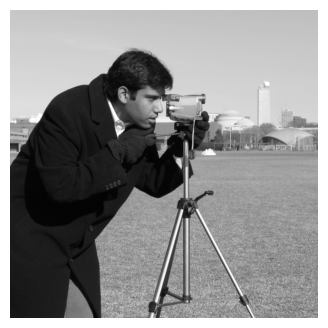

In [1]:
from skimage import data
import matplotlib.pyplot as plt

# Load and visualize a sample image
camera = data.camera()
plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
plt.axis('off')
plt.show()

In [2]:
import numpy as np

# Initialize the edge detection kernel
# kernel(numpy.array): kernel for edge detection with size of (3*3)
kernel = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
kernel = kernel / 8.0
print(f'Edge detection kernel:\n\n {kernel}')

Edge detection kernel:

 [[-0.125 -0.125 -0.125]
 [-0.125  1.    -0.125]
 [-0.125 -0.125 -0.125]]


## 1.1 Numpy 2D Convolution
Write a double for loop to convolve the edge detection kernel from the above code cell with the camera image. 

- Apply the filter with `stride=2` and `pad=0`. 
- Your output's width should be. Similarly, you can find the length of the output. You can find the complete formula in the [slides posted on moodle](https://moodle.concordia.ca/moodle/pluginfile.php/5884784/mod_resource/content/1/Lecture%205.pdf).
- Plot the absolute value of the edge detection output using matplotlib's `imshow`.

You can refer to this [example of 2D convolution](https://www.songho.ca/dsp/convolution/convolution2d_example.html) when implementing your code.

Your final output should look like the image below.

<center>
<!-- <img src="https://drive.google.com/uc?id=11fFJ3QrbF87w8ChZF45p-5uXtmxZU8Qv"> camera image from old library version! -->
<img src="https://drive.google.com/uc?id=1bgjdeF1Ls20586nzsG2mqqo7RTtTkXR4">


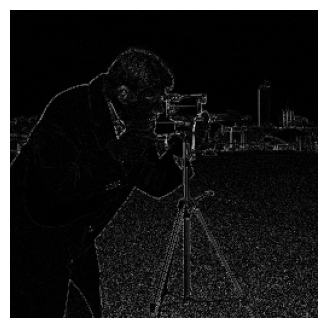

108.125


In [3]:
import torch
import torch.nn as F
# height and width of the image
H, W = camera.shape

# stride of the convolution
stride = 2

pad=0

# edge detection kernel size
kernel_size = kernel.shape[0]


### TODO: convolve edge detection kernel with the camera image
###       and store the result in the variable 'output'


output = np.zeros(((W-kernel_size)//stride+1, (H-kernel_size)//stride+1))

for i in range(0, W-kernel_size+1, stride):
    for j in range(0, H-kernel_size+1, stride):
        output[i//stride, j//stride] = np.sum(camera[i:i+kernel_size, j:j+kernel_size] * kernel)


# Visualize the absolute output of the convolution
plt.figure(figsize=(4, 4))
plt.imshow(np.abs(output), cmap='gray')
plt.axis('off')
plt.show()
print(np.max(np.abs(output)))




# Exercise 2: PyTorch Convolution

Now let's take a look at `torch.nn.conv2d`. 

Run the cell below to convolve 5 random kernels on the camera man image and see the shapes of the parameters.


**Note:** An image tensor has the following dimensions $(N,C,H,W)$, where $N$ is the batch size/number of images and $C$ is the number of color channels. In this exercise you only have 1 image!


In [4]:
import torch

# initialize convolutional kernel
conv_nn = torch.nn.Conv2d(1, 5, kernel_size=3, stride=2)

# set the kernel bias to zero
conv_nn.bias.data.zero_()

# convert camera image to a torch.tensor of shape (1, 1, H, W)
img_in = torch.tensor(camera, dtype=torch.float32)[None, None, :, :]

# forward pass
filtered_camera = conv_nn(img_in)

print(f'output shape (batch_size, in_channels, H, W): {filtered_camera.shape}')
print(f'kernel shape (out_channels, in_channels, kernel_size[0], kernel_size[1]): {conv_nn.weight.data.shape}\n')

# to compute the output keep in mind these variables and the formula for H,W output in torch.nn.Conv2d
print('Convolution layer parameters:')
print(f'Dilation: {conv_nn.dilation}')
print(f'Stride: {conv_nn.stride}')
print(f'Padding: {conv_nn.padding}')
print(f'Kernel size: {conv_nn.kernel_size}')


output shape (batch_size, in_channels, H, W): torch.Size([1, 5, 255, 255])
kernel shape (out_channels, in_channels, kernel_size[0], kernel_size[1]): torch.Size([5, 1, 3, 3])

Convolution layer parameters:
Dilation: (1, 1)
Stride: (2, 2)
Padding: (0, 0)
Kernel size: (3, 3)


## 2.1 Functional 2D Convolution

Consider a minibatch of a randomly generated images (`toy_train_images`). Pass these images through the randomly initialized convolutional layer above.

Take the weights from the convolution layer above and implement the convolution. You can use nested for loops. 

**Note**: By default, PyTorch uses channels first representation of images $(N, C, H, W)$ as opposed to $(N, H, W, C)$, where $N=$ number of samples, $H=$ image height, $W=$ image width, and $C=$ number of image channels, e.g. 3 for rgb).


In [5]:
import torch.nn as nn
import copy

# toy minibatch hyperparameters
mini_batch = 10
height, width = (12, 12)
in_channels = 1
out_channels = 5

# generating minibatch from uniform distribution
toy_train_images = torch.rand(mini_batch, in_channels, height, width) 


### TODO: Copy the weights from previous cell's convolution layer
### Hint: You can use copy.deepcopy
my_weights = copy.deepcopy(conv_nn.weight.data)

def my_conv_nn(X, kernel_weights):
    """Uses a double for loop to convolve the input image `x` with `my_weights`
    with a fixed stride of 2.

    Args:
        X (torch.Tensor): a minibatch of images of shape (batch_size, in_channels, H, W)

    Returns:
        (torch.Tensor): Convolution result

    Shape:
        - X: Of shape (N, C_in, H_in, W_in)
        - kernel_weights: Of shape (C_out, C_in, 3, 3)
        - output: (N, C_out, H_out, W_out)
    """
    # convolution hyperparameters
    H, W = (height, width)
    stride = 2

    # initialize output tensor
    output = torch.zeros((mini_batch, out_channels, (H-3)//stride+1, (W-3)//stride+1))
    print(output.shape)

    ### TODO: Use for loop to implement a convolution

    for i in range(0, H-3+1, stride):
        for j in range(0, W-3+1, stride):
            output[:, :, i//stride, j//stride] =  torch.sum(X[:, :, i:i+3, j:j+3] * kernel_weights.transpose(0,1), dim=(2, 3))

    return output

Confirm your custom function has the same behavior as `torch.nn.Conv2d` on the camera image.

In [6]:
my_out = my_conv_nn(toy_train_images, my_weights) # outputs the convolution using the function above
torch_out = conv_nn(toy_train_images) # outputs the convolution using the nn.Conv2d layer
assert my_weights.shape == (5, 1, 3, 3), f"Incorrect shape for 'my_weights' ({my_weights.shape})."
assert torch.is_tensor(my_out), "Your function output is not a torch.Tensor"
assert my_out.shape == torch_out.shape, f"Incorrect output shape ({my_out.shape})."
assert torch.norm(my_out - torch_out) < 1e-3, "Incorrect function output values compared to torch module"
print('Well done! Your function has the same behaviour as torch.nn.Conv2d')

torch.Size([10, 5, 5, 5])
Well done! Your function has the same behaviour as torch.nn.Conv2d


## 2.2 Modular 2D Convolution

Build a small convnet using `torch.nn.Module` with two layers and forward pass the astronaut image from `skimage` through it.

**Note:** You do not need to train the model for this exercise. You should only use the `torch.nn.Conv2d` for this part.

The convnet should have the following specifications:<br>

* Activation Function: `ReLU` <br>
* Layer1: filter size `(5,5)`, out_channels `16`, stride `2` convolution layer <br>
* Layer2: `(2,2)` pooling layer <br>
* Layer3: filter size `(3,3)`, out_channels `32`, stride `2` convolution layer <br>
* Layer4: linear layer with `5` output units. Note that for the number of input neurons to the linear layer, you need to keep track of the shape of the image as it passes through the CNN using the formula in [the lecture slides](https://https://moodle.concordia.ca/moodle/pluginfile.php/5884784/mod_resource/content/1/Lecture%205.pdf).


In your forward function add print statements to show the size of the image at each layer. 


astronaut.shape: (512, 512, 3)


(-0.5, 511.5, 511.5, -0.5)

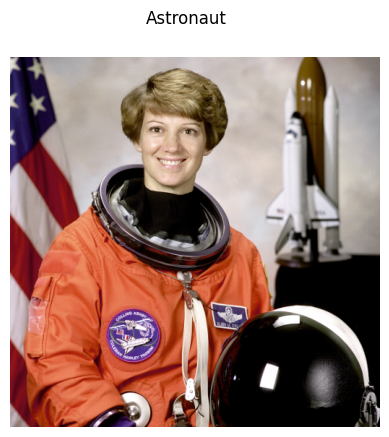

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data


# load and the astronaut image
astronaut_np = data.astronaut()
print(f"astronaut.shape: {astronaut_np.shape}")

# visualize the original and preprocessed astronaut image
# fig, ax = plt.subplots(1, 1)
fig = plt.figure()
fig.suptitle("Astronaut")
plt.imshow(astronaut_np)
plt.axis('off')

Run below cell to convert the astronaut image into a tensor and reshape it into the shape that PyTorch expects.

In [8]:
# convert the astronaut image to torch.tensor
astronaut = torch.tensor(astronaut_np, dtype=torch.float32)

# torch convolutions expect channels first representation
# of shape (N, C, H, W)
astronaut = astronaut.permute(2, 0, 1).unsqueeze(0)
print(f'astronaut.shape: {astronaut.shape}')

astronaut.shape: torch.Size([1, 3, 512, 512])


In [13]:
import torch
import torch.nn.functional as F
from skimage import data

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        ### TODO: Define layers based on description above
        #Layer1: filter size `(5,5)`, out_channels `16`, stride `2` convolution layer 
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=5, stride=2)
        #Layer2: max pooling layer with kernel size `(2,2), stride `2`
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        #Layer3: filter size `(3,3)`, out_channels `32`, stride `2` convolution layer
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        #5 output units
        self.linear = torch.nn.Linear(32*63*63, 5)

      
    def forward(self, x):
        ### TODO: Compelete forward pass, print image size after each layer
        x = F.relu(self.conv1(x))
        print(f'conv1 output shape: {x.shape}')
        x = self.pool(x)
        print(f'pool output shape: {x.shape}')
        x = F.relu(self.conv2(x))
        print(f'conv2 output shape: {x.shape}')
        x = x.view(-1, 32*63*63)
        x = self.linear(x)
        print(f'linear output shape: {x.shape}')
        return x


model = MyModel()
model(astronaut)

print(model)

# feature_map = []
# names = []
# layers = list(layer for layer in model.children() if isinstance(layer, torch.nn.Conv2d))

# feature_map.append(layers[0](astronaut))
# for i in range(1, len(layers)):
#     feature_map.append(layers[i](feature_map[-1]))

# # visualize the feature maps
# for layer in range(len(feature_map)):
#     fig = plt.figure()
#     fig.suptitle(f"Feature map of layer {layer+1}")
#     layer_viz = feature_map[layer][0, :, :, :]
#     layer_viz = layer_viz.data
#     print(f"feature_map[{layer}].shape: {layer_viz.shape}")
#     for i, filter in enumerate(layer_viz):
#         if i == 6:
#             break
#         ax1 = fig.add_subplot(2, 3, i+1)
#         ax1.imshow(filter)
#         ax1.axis("off")
#         ax1.set_xticklabels([])
#         ax1.set_yticklabels([])

# plt.show()









conv1 output shape: torch.Size([1, 16, 254, 254])
pool output shape: torch.Size([1, 16, 127, 127])
conv2 output shape: torch.Size([1, 32, 63, 63])
linear output shape: torch.Size([1, 5])
MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (linear): Linear(in_features=127008, out_features=5, bias=True)
)


# Exercise 3: Pretrained AlexNet Model


In this section, we will visualize a subset of the first layer filters of the pretrained AlexNet and the result of applying these filters to the astronaut image. 

Run the below cell to download the trained [AlexNet](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) model using [PyTorch Hub](https://pytorch.org/docs/stable/hub.html)'s [`torch.hub.load()`](https://pytorch.org/docs/stable/hub.html#torch.hub.load) method. The model is switched to `eval()` mode since we will not be doing any training in this lab:

In [15]:
import torch

# load the alexnet model using pytorch hub from:
# https://github.com/pytorch/vision/blob/winbuild/v0.6.0/torchvision/models/alexnet.py
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)

# switch the model to "eval" mode since we are not doing any further training
model.eval()

# print the model architecture
print(model)

Using cache found in C:\Users\x_zhu202/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 3.1 Input data to the AlexNet

Since we are using a pretrained model, we need to make sure that our data has a similar distribution to the training data that the model was trained on. For our case here, this means that we need to preprocess the data in a similar manner to how it was done in the [original training pipeline](https://github.com/pytorch/examples/blob/97304e232807082c2e7b54c597615dc0ad8f6173/imagenet/main.py#L197-L198).

Run the below cell to preprocess and visualize the astronaut image.

(-0.5, 511.5, 511.5, -0.5)

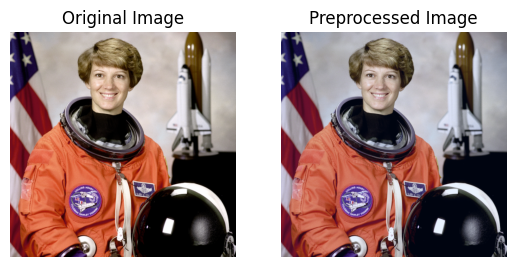

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data

def image_normalizer(image):
    r"""Normalizes the input to scale [0 1].

    Args:
        image (np.ndarray or torch.Tensor): image to be rescaled

    Returns:
        (np.ndarray or torch.Tensor): rescaled image

    Shape:
        - image: (*) Any shape
        - output: Same shape as input
    """
    return (image - image.min()) / (image.max() - image.min())

# the mean and standard deviations of ImageNet dataset 
# that were used for preprocessing AlexNet training data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# preprocess the astronaut image from the part 2
astronaut_processed = astronaut / 255.0
astronaut_processed = (astronaut_processed - mean[None, :, None, None]) / std[None, :, None, None]

# visualize the original and preprocessed astronaut image
astro_processed_np = astronaut_processed.squeeze().permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Original Image")
ax[0].imshow(astronaut_np)
ax[0].axis('off')
ax[1].set_title("Preprocessed Image")
ax[1].imshow(image_normalizer(astro_processed_np))
ax[1].axis('off')

## 3.2 Visualizing AlexNet Kernels

The kernels (filters) in the first layer of AlexNet are of size 11. Visualize a randomly selected subset of 20 of these first layer filters as well as the respective output of convolving each kernel with the astronaut image. You can use either pytorch `F.conv2d` or your custom convolution implementation. 

Remember that the shape of the input is (# of images, # of color channels, H,W), the shape of a kernel is (# of out channels, # of in channels, H,W), and the shape of the output image is (# of images, # of color channels, H,W)

Your answer will look something like this
<center>
<img src="https://drive.google.com/uc?id=1azdohWuo3EEO9KC0szZmJOywX54jXlPz">

torch.Size([64, 3, 11, 11])
convolved_outputs.shape: (1, 64, 127, 127)


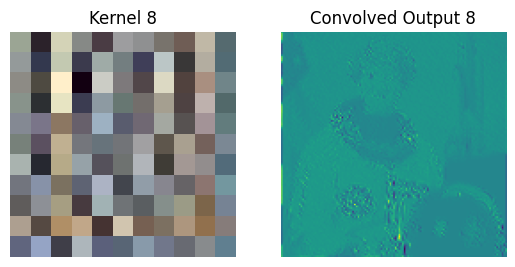

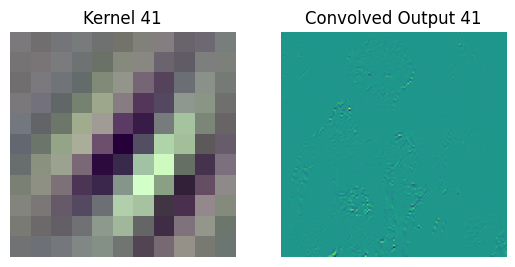

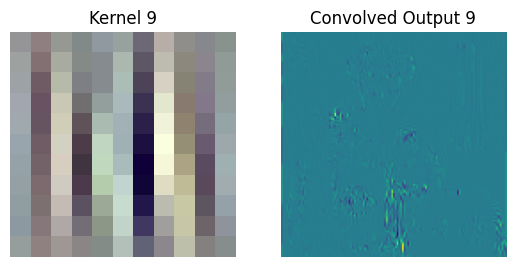

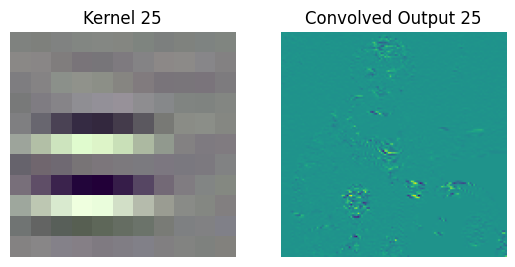

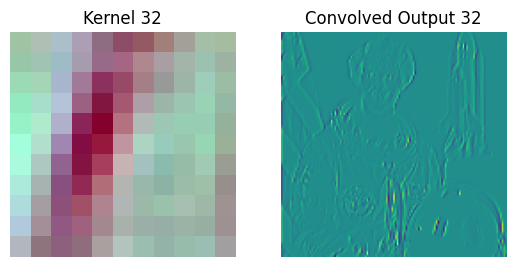

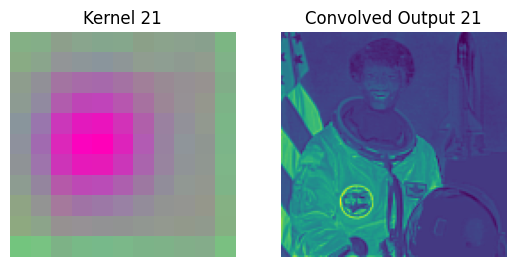

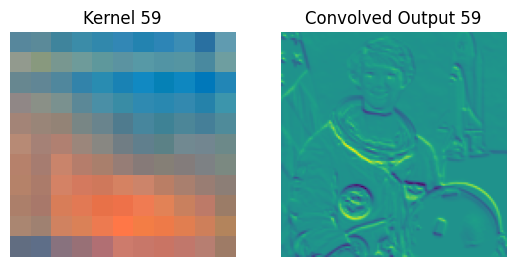

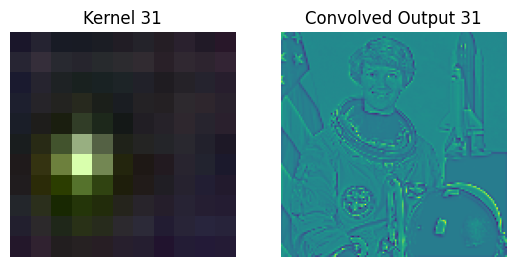

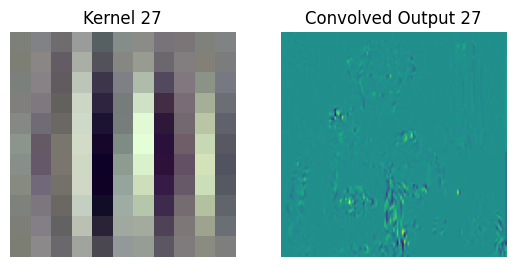

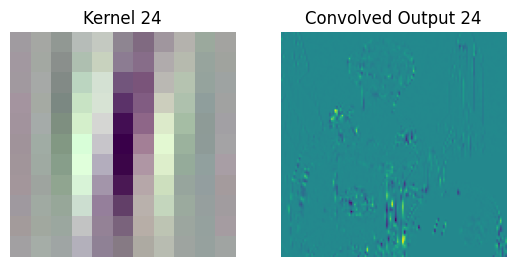

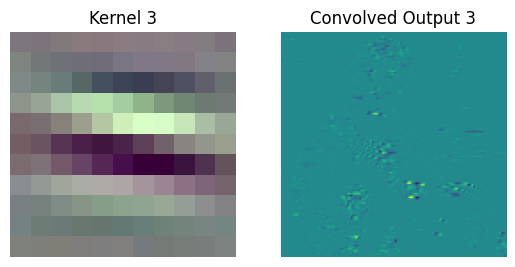

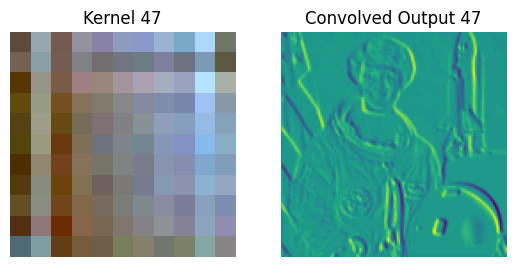

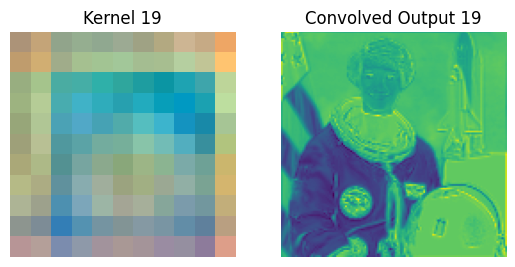

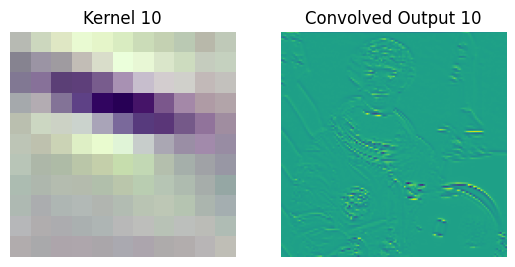

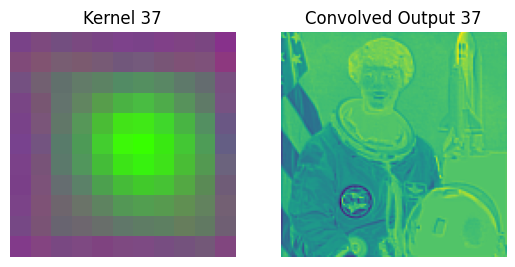

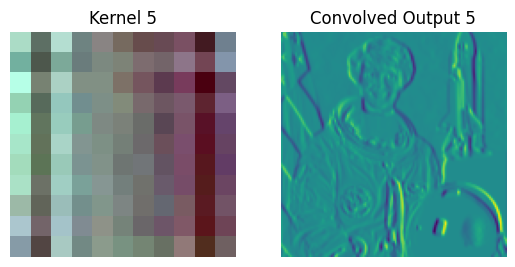

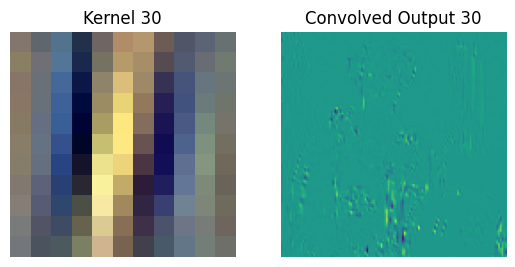

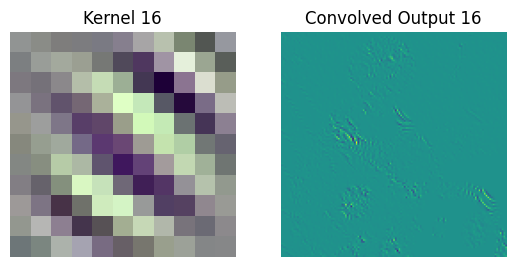

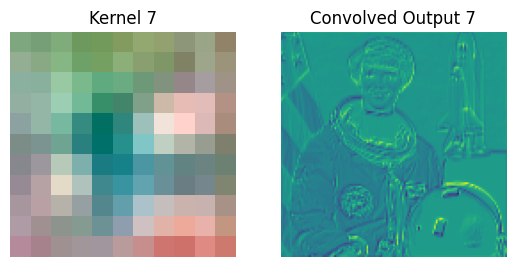

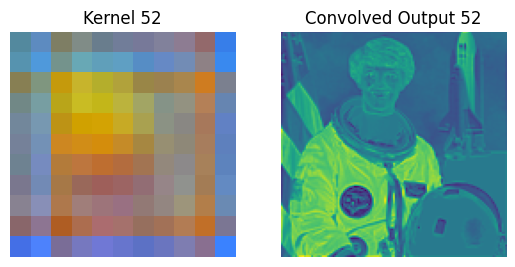

In [73]:
# random seed
np.random.seed(691)

# get the weights of the first layer's kernels of the model
# https://github.com/pytorch/vision/blob/9dff1b40ee9741216686556cc59fbf16964c8156/torchvision/models/alexnet.py#L18
conv_sequential = model.features
conv0 = conv_sequential[0]
conv0_weights = conv0.weight

# indices of kernels to show
random_inds = np.random.permutation(64)[0:20]

### TODO: convolve the astronaut image with the kernel weights and obtain the outputs

astro_tensor = torch.tensor(astro_processed_np, dtype=torch.float32).permute(2,0,1).unsqueeze(0)

convolved_outputs = conv0(astro_tensor).detach().numpy()

print(conv0_weights.shape)

print(f'convolved_outputs.shape: {convolved_outputs.shape}')

### TODO: plot 10 kernels corresponding to the 10 indices in `random_inds` and 
### their convolution outputs. You may use the provided `image_normalizer()`
### function in above cell for scaling the kernel weights and outputs
### for visualization.
for i, ind in enumerate(random_inds):
    # if i == 10:
    #     break
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title(f"Kernel {ind}")
    #print(conv0_weights[ind].T.shape)
    ax[0].imshow(image_normalizer(conv0_weights[ind].permute(1,2,0).detach().numpy().squeeze()), cmap='gray')
    ax[0].axis('off')
    ax[1].set_title(f"Convolved Output {ind}")
    ax[1].imshow(image_normalizer(convolved_outputs[0, ind]))
    ax[1].axis('off')
    

